# Child Mind Institute - Problematic Internet Usage

To do:
- [ ] include [hyperparameter tuning](https://www.kaggle.com/code/sankalpsrivastava26/catboost-hyperparameter-tuning)
- [ ] try imputing missing values
- [ ] use feature reduction techniques?
- [ ] Use semi-supervised learning
- [ ] Process actigraphy data more

**Make sure that if you do something to the train dataset that you also do it to the test dataset.**

In [7]:
# -----------------------------------------
# notebook settings
# -----------------------------------------

# data location (change if not on Kaggle)
#dir = "/kaggle/input/child-mind-institute-problematic-internet-use/"

# drop rows with high missingness?
drop_high_misssing_rows = False
row_missing_thresh = 50 # rows with x% will be dropped

# include prcoessed actigraphy data?
include_PA = True

# hyperparameter tuning?
tuning = True

# imputation?
imputation = True

# feature extraction/selection
feature_extraction = True

# drop rows missing target?
drop_missing_target = True

# semi-supervised learning? (won't drop missing target if you do this)
semisupervised_learning = ~drop_missing_target

In [15]:
pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.3 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 24.2
    Uninstalling pip-24.2:
      Successfully uninstalled pip-24.2
Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install wheel

Note: you may need to restart the kernel to use updated packages.


In [11]:
# -----------------------------------------
# Install (if necessary) and load libraries
# -----------------------------------------

# !pip install optuna
# !pip install catboost
# !pip install polars

import warnings
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import optuna
import polars as pl
import polars.selectors as cs
from catboost import CatBoostRegressor, MultiTargetCustomMetric
from numpy.typing import ArrayLike, NDArray
from polars.testing import assert_frame_equal
from sklearn.base import BaseEstimator
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings("ignore", message="Failed to optimize method")

ModuleNotFoundError: No module named 'catboost'

In [136]:
TARGET_COLS = [
    "PCIAT-PCIAT_01",
    "PCIAT-PCIAT_02",
    "PCIAT-PCIAT_03",
    "PCIAT-PCIAT_04",
    "PCIAT-PCIAT_05",
    "PCIAT-PCIAT_06",
    "PCIAT-PCIAT_07",
    "PCIAT-PCIAT_08",
    "PCIAT-PCIAT_09",
    "PCIAT-PCIAT_10",
    "PCIAT-PCIAT_11",
    "PCIAT-PCIAT_12",
    "PCIAT-PCIAT_13",
    "PCIAT-PCIAT_14",
    "PCIAT-PCIAT_15",
    "PCIAT-PCIAT_16",
    "PCIAT-PCIAT_17",
    "PCIAT-PCIAT_18",
    "PCIAT-PCIAT_19",
    "PCIAT-PCIAT_20",
    "PCIAT-PCIAT_Total",
    "sii",
]

# Actigraphy Processing
Commented out since it takes a while to run and uploaded the datasets instead. Should do a final submission with the actigraphy processing included once I decide on the final model.

In [137]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import os
# import datetime
# from tqdm import tqdm

In [138]:
# # all participant data to loop over
# base_dir = '/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet'
# subdirs = os.listdir(base_dir)
# pids = [s.replace('id=', '') for s in subdirs]

In [139]:
# # functions that can be used for each participant
# def read_parquet(pid):
#     # Construct the full path to the Parquet file
#     file_path = os.path.join(base_dir, 'id='+pid, 'part-0.parquet')
    
#     # Read the Parquet file into a DataFrame
#     df = pd.read_parquet(file_path)

#     return df

# def format_time(t):
#     # Convert string to integer (assuming it's in nanoseconds)
#     nanoseconds = int(t)
    
#     # Convert nanoseconds to a timedelta object
#     time_delta = datetime.timedelta(microseconds=nanoseconds / 1000)  # Convert nanoseconds to microseconds

#     # Format the timedelta to the desired format
#     formatted_time = str(time_delta)
    
#     # Optionally, if you want to match exactly the "%H:%M:%S.%9f" format
#     hours, remainder = divmod(time_delta.seconds, 3600)
#     minutes, seconds = divmod(remainder, 60)
#     microseconds = time_delta.microseconds

#     # Format with leading zeros if necessary
#     return f"{hours:02}:{minutes:02}:{seconds:02}"

# def create_datetime_col(df):
#     base_date = pd.to_datetime('2024-11-14')  # Initialize date from a first relative date (not the real date)
#     df['date'] = df['relative_date_PCIAT'].apply(lambda x: base_date + pd.to_timedelta(x, unit='D'))
#     df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['formatted_time'])
#     df = df.drop(columns=['date'])
#     return df

# def plot_participant_activity(df):
#     dates = df['datetime'].dt.date.unique()
#     plt.figure(figsize=(10,5))
#     for i in range(len(dates)):
#         filtered_df = df[df['datetime'].dt.date == dates[i]].copy()
        
#         # Convert time to minutes since midnight
#         filtered_df['time_in_minutes'] = filtered_df['datetime'].dt.hour * 60 + filtered_df['datetime'].dt.minute
        
#         # Plot the data
#         sns.lineplot(x=filtered_df['time_in_minutes'], y=filtered_df['enmo'], alpha = 0.3, errorbar=None)
        
#         plt.xticks(rotation=90)
    
#     # format plot
#     plt.title('Participant Activity Patterns During Day')
#     plt.xlabel('Time of Day (min)')
    
#     # Show the plot
#     plt.show()


# # Should we do subsampling? We only need to do this if our computers can't handle this amount of data

# # How should we deal with idle_sleep_mode? 
# # During periods of no motion, the watch will not record any data. 
# # So we could be understating that amount of sedentary periods if we don’t account for this somehow.


# # activity levels (using enmo)
# def get_activity_levels(df, thresholds = (0.0563, 0.1916, 0.6958)):
#     """
#     Returns the percent of time spent sedentary or doing light, moderate, or vigorous activity.
#     The percent of time is dependent on the amount of data we have for each participant.

#     Args:
#         df: a single participant's enom measurements over time
#         thresholds: tuple of light, moderate, and vigorous physical activity thresholds (Hildebrand 2014)
#     """
#     light_threshold = thresholds[0]
#     moderate_threshold = thresholds[1]
#     vigorous_threshold = thresholds[2]
    
#     # Create a function to classify the activity level
#     def classify_activity(enmo_value):
#         if enmo_value <= light_threshold:
#             return 'sendentary'
#         elif enmo_value <= moderate_threshold:
#             return 'light'
#         elif enmo_value <= vigorous_threshold:
#             return 'moderate'
#         else:
#             return 'vigorous'
    
#     # Apply the function to the ENMO series
#     activity_level_series = df['enmo'].apply(classify_activity)
#     activity_level_series = activity_level_series.value_counts() / len(activity_level_series)
#     activity_level_dict = dict(activity_level_series)
#     return activity_level_dict

In [140]:
# # process train actigraphy data
# activity_level_list = []
# for pid in tqdm(pids, desc="Processing pids", unit="pid"):
#     df = read_parquet(pid)
#     df['formatted_time'] = df['time_of_day'].apply(format_time)
#     df = create_datetime_col(df)
#     activity_level_list.append(get_activity_levels(df))
# PA_data = pd.DataFrame(activity_level_list, index=pids)
# PA_data.to_csv('data/PA_data.csv')

In [141]:
# # process test actigraphy data
# base_dir = '/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet'
# subdirs = os.listdir(base_dir)
# pids = [s.replace('id=', '') for s in subdirs]
# activity_level_list = []
# for pid in tqdm(pids, desc="Processing pids", unit="pid"):
#     df = read_parquet(pid)
#     df['formatted_time'] = df['time_of_day'].apply(format_time)
#     df = create_datetime_col(df)
#     activity_level_list.append(get_activity_levels(df))
# PA_data = pd.DataFrame(activity_level_list, index=pids)
# PA_data.to_csv('data/PA_data_test.csv')

# Survey Processing

In [142]:
# Load data using pandas (instead of polars liek Jagruta did)
data_dictionary = pd.read_csv(dir + "data_dictionary.csv")
train_data = pd.read_csv(dir + "train.csv")
test_data = pd.read_csv(dir + "test.csv")

# read aggregated actigraphy
actigraphy_data = pd.read_csv('/kaggle/input/pa-data/PA_data.csv', index_col=0)
test_actigraphy_data = pd.read_csv('/kaggle/input/pa-data/PA_data_test.csv', index_col=0)

In [143]:
# define target columns to multiple regression
TARGET_COLS = [
    "PCIAT-PCIAT_01",
    "PCIAT-PCIAT_02",
    "PCIAT-PCIAT_03",
    "PCIAT-PCIAT_04",
    "PCIAT-PCIAT_05",
    "PCIAT-PCIAT_06",
    "PCIAT-PCIAT_07",
    "PCIAT-PCIAT_08",
    "PCIAT-PCIAT_09",
    "PCIAT-PCIAT_10",
    "PCIAT-PCIAT_11",
    "PCIAT-PCIAT_12",
    "PCIAT-PCIAT_13",
    "PCIAT-PCIAT_14",
    "PCIAT-PCIAT_15",
    "PCIAT-PCIAT_16",
    "PCIAT-PCIAT_17",
    "PCIAT-PCIAT_18",
    "PCIAT-PCIAT_19",
    "PCIAT-PCIAT_20",
    "PCIAT-PCIAT_Total",
    "sii",
]

## Train

In [144]:
# TRAIN
# Outliers ----------------------------------------------------------------------------
# removing outliers (should change this to be automatic so it applies to the test data)
# From CGAS
train_data.loc[2065, 'CGAS-CGAS_Score'] = 99
# From BIA (there might still be some suspicious extreme values)
cols = data_dictionary.loc[(data_dictionary['Instrument'] == 'Bio-electric Impedance Analysis') & (data_dictionary['Type'] == 'float'), 'Field']
train_data.loc[[3205, 3511], cols] = np.nan # remove 3511 and 3205's BIA values because they seem wrong. They have normal heights and weights but extreme values for BIA measures

# Drop features ----------------------------------------------------------------------
# combine FitnessGram Minutes and seconds
train_data['Fitness_Endurance-Total_Time_sec'] = train_data['Fitness_Endurance-Time_Mins'] * 60 + train_data['Fitness_Endurance-Time_Sec'] # remove remaining Fitness_Endurance Columns
# drop any column that ends in -Season, remaining Fitness_Endurance columns, and redundant SDS column
columns_to_drop = [col for col in train_data.columns if col.endswith('Season')]
columns_to_drop.extend(['Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Sec', 'Fitness_Endurance-Time_Mins', 'SDS-SDS_Total_Raw'])
train_data_cleaned = train_data.drop(columns=columns_to_drop)

# merge PAQ_A and PAQ_C
# keep adolescent value if 13 or older
train_data_cleaned.loc[train_data_cleaned['PAQ_A-PAQ_A_Total'].notna() & train_data_cleaned['PAQ_C-PAQ_C_Total'].notna() & (train_data_cleaned['Basic_Demos-Age'] >= 13), 'PAQ_C-PAQ_C_Total'] = np.nan
# keep child value is younger than 13
train_data_cleaned.loc[train_data_cleaned['PAQ_A-PAQ_A_Total'].notna() & train_data_cleaned['PAQ_C-PAQ_C_Total'].notna() & (train_data_cleaned['Basic_Demos-Age'] < 13), 'PAQ_A-PAQ_A_Total'] = np.nan
# merge columns
train_data_cleaned['PAQ-PAQ_Total'] = train_data_cleaned['PAQ_A-PAQ_A_Total'].fillna(train_data_cleaned['PAQ_C-PAQ_C_Total'])
# drop columns
train_data_cleaned = train_data_cleaned.drop(columns = ['PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total'])

In [145]:
# include aggregate acitgraphy features
if include_PA:
    train_data_cleaned = pd.merge(train_data_cleaned, actigraphy_data, left_on='id', how='left', right_index=True)

In [146]:
# drop rows with high missingness (unsuccessful)
if drop_high_misssing_rows:
# Drop rows with high missingness (should investigate characteristics of rows with high missingness)
# Might not want to drop rows with high missingness because there are also rows with high missingness in the test dataset
    percent_missing_per_row = train_data_cleaned.isnull().mean(axis=1) * 100
    high_missingness_idx = percent_missing_per_row[percent_missing_per_row > row_missing_thresh].index.values
    train_data_cleaned = train_data_cleaned.drop(high_missingness_idx)
    print(f'{len(high_missingness_idx)} rows dropped because {thresh}% or more of the data was missing.')
    print(f'There are {len(train_data_cleaned)} rows remaining in the train data.')

In [147]:
# Drop features with high missingness?
print('This is the proportion of data available per feature. It might be wise to drop features with high missingness. We can try both ways though.')
display(train_data_cleaned.notna().mean().sort_values())

This is the proportion of data available per feature. It might be wise to drop features with high missingness. We can try both ways though.


Fitness_Endurance-Total_Time_sec          0.186616
Physical-Waist_Circumference              0.226768
vigorous                                  0.243687
moderate                                  0.251010
light                                     0.251515
                                            ...   
Physical-Weight                           0.776768
PreInt_EduHx-computerinternet_hoursday    0.833586
Basic_Demos-Sex                           1.000000
Basic_Demos-Age                           1.000000
id                                        1.000000
Length: 71, dtype: float64

In [148]:
# Impute/interpolate remaining missing values (not necessary for CATBoost)
if imputation:
    pass # fill out

In [149]:
# Convert categorical columns to the correct data type? Since they're ordinal, it's probably not necessary to convert anything
# use data dictionary to convert features that have type=="categorical int" into str dtype


In [150]:
# drop rows without target
if drop_missing_target:
    train_data_cleaned = train_data_cleaned.dropna(subset=TARGET_COLS)

In [151]:
print(f'Final length of the training dataset: {len(train_data_cleaned)}')

Final length of the training dataset: 2671


## Test

In [152]:
# Drop features ----------------------------------------------------------------------
# combine FitnessGram Minutes and seconds
test_data['Fitness_Endurance-Total_Time_sec'] = test_data['Fitness_Endurance-Time_Mins'] * 60 + test_data['Fitness_Endurance-Time_Sec'] # remove remaining Fitness_Endurance Columns
# drop any column that ends in -Season, FitnessGram Zones, remaining Fitness_Endurance columns, and redundant SDS column
columns_to_drop = [col for col in test_data.columns if col.endswith('Season')]
columns_to_drop.extend(['Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Sec', 'Fitness_Endurance-Time_Mins', 'SDS-SDS_Total_Raw'])
test_data_cleaned = test_data.drop(columns=columns_to_drop)

# merge PAQ_A and PAQ_C
# keep adolescent value if 13 or older
test_data_cleaned.loc[test_data_cleaned['PAQ_A-PAQ_A_Total'].notna() & test_data_cleaned['PAQ_C-PAQ_C_Total'].notna() & (test_data_cleaned['Basic_Demos-Age'] >= 13), 'PAQ_C-PAQ_C_Total'] = np.nan
# keep child value if younger than 13
test_data_cleaned.loc[test_data_cleaned['PAQ_A-PAQ_A_Total'].notna() & test_data_cleaned['PAQ_C-PAQ_C_Total'].notna() & (test_data_cleaned['Basic_Demos-Age'] < 13), 'PAQ_A-PAQ_A_Total'] = np.nan
# merge columns
test_data_cleaned['PAQ-PAQ_Total'] = test_data_cleaned['PAQ_A-PAQ_A_Total'].fillna(test_data_cleaned['PAQ_C-PAQ_C_Total'])
# drop columns
test_data_cleaned = test_data_cleaned.drop(columns = ['PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total'])

In [153]:
# include aggregate actigraphy features
if include_PA:
    test_data_cleaned = pd.merge(test_data_cleaned, test_actigraphy_data, left_on='id', how='left', right_index=True)

In [154]:
# can't drop these rows in the test set
percent_missing_per_row = test_data_cleaned.isnull().mean(axis=1) * 100
print('This is the percent missing per row. Some participants only have a few records.')
display(percent_missing_per_row)

This is the percent missing per row. Some participants only have a few records.


0     30.612245
1     20.408163
2     42.857143
3     10.204082
4     91.836735
5      4.081633
6     22.448980
7     14.285714
8     91.836735
9     93.877551
10    93.877551
11    85.714286
12    14.285714
13    48.979592
14    91.836735
15    53.061224
16    55.102041
17    61.224490
18    20.408163
19    91.836735
dtype: float64

In [155]:
# Drop features with high missingness? Has to match features dropped for training data
print('\nThis is the proportion of data available per feature. It might be wise to drop features with high missingness. We can try both ways though.')
display(test_data_cleaned.notna().mean().sort_values())


This is the proportion of data available per feature. It might be wise to drop features with high missingness. We can try both ways though.


vigorous                                  0.10
light                                     0.10
sendentary                                0.10
moderate                                  0.10
Fitness_Endurance-Total_Time_sec          0.15
FGC-FGC_GSD_Zone                          0.25
FGC-FGC_GSND_Zone                         0.25
FGC-FGC_GSND                              0.25
FGC-FGC_GSD                               0.25
Physical-Waist_Circumference              0.25
BIA-BIA_Frame_num                         0.40
BIA-BIA_DEE                               0.40
BIA-BIA_BMR                               0.40
BIA-BIA_BMI                               0.40
BIA-BIA_BMC                               0.40
BIA-BIA_Activity_Level_num                0.40
CGAS-CGAS_Score                           0.40
BIA-BIA_FFMI                              0.40
BIA-BIA_FMI                               0.40
BIA-BIA_Fat                               0.40
BIA-BIA_FFM                               0.40
BIA-BIA_ICW  

In [156]:
# Impute/interpolate remeaining missing values (not necessary for CATBoost)
if imputation:
    pass # fill out

In [157]:
# Convert categorical columns to the correct data type? Since they're ordinal, probably don't have to convert
# use data dictionary to convert features that have type=="categorical int" into str dtype
# only do this if you also do it on the train

In [158]:
print(f'Final length of the test dataset: {len(test_data_cleaned)}')

Final length of the test dataset: 20


## Final Datasets

In [159]:
# select X and y
X = train_data_cleaned.drop(columns = TARGET_COLS + ['id']).reset_index(drop=True)
X_test = test_data_cleaned.drop(columns = ['id']).reset_index(drop=True)

# check that train and test have matching columns
print(f'Same column in train and test: {pd.Series(X.columns).isin(X_test.columns).sum() == X.shape[1]}')

# train target
y = train_data_cleaned[TARGET_COLS].reset_index(drop=True)
y_sii = y["sii"].to_numpy() # ground truth

Same column in train and test: True


In [160]:
class MultiTargetQWK(MultiTargetCustomMetric):
    #Custom evaluation during model training for tasks with ordered or multi-target outputs
    def get_final_error(self, error, weight):
        return np.sum(error)  # / np.sum(weight)

    def is_max_optimal(self):
        # if True, the bigger the better
        return True

    def evaluate(self, approxes, targets, weight):
        approx = np.clip(approxes[-1], 0, 3).round().astype(int)
        target = targets[-1]

        qwk = cohen_kappa_score(target, approx, weights="quadratic")

        return qwk, 1

    def get_custom_metric_name(self):
        return "MultiTargetQWK"


class OptimizedRounder:
  #Improves classification accuracy by learning optimal decision thresholds for rounding continuous model outputs into discrete classes
    def __init__(self, n_classes: int, n_trials: int = 100):
        self.n_classes = n_classes
        self.labels = np.arange(n_classes)
        self.n_trials = n_trials
        self.metric = partial(cohen_kappa_score, weights="quadratic")

    def fit(self, y_pred: NDArray[np.float_], y_true: NDArray[np.int_]) -> None:
        y_pred = self._normalize(y_pred)

        def objective(trial: optuna.Trial) -> float:
            thresholds = []
            for i in range(self.n_classes - 1):
                low = max(thresholds) if i > 0 else min(self.labels)
                high = max(self.labels)
                th = trial.suggest_float(f"threshold_{i}", low, high)
                thresholds.append(th)
            try:
                y_pred_rounded = np.digitize(y_pred, thresholds)
            except ValueError:
                return -100
            return self.metric(y_true, y_pred_rounded)

        optuna.logging.disable_default_handler()
        study = optuna.create_study(direction="maximize")
        study.optimize(
            objective,
            n_trials=self.n_trials,
        )
        self.thresholds = [study.best_params[f"threshold_{i}"] for i in range(self.n_classes - 1)]

    def predict(self, y_pred: NDArray[np.float_]) -> NDArray[np.int_]:
        assert hasattr(self, "thresholds"), "fit() must be called before predict()"
        y_pred = self._normalize(y_pred)
        return np.digitize(y_pred, self.thresholds)

    def _normalize(self, y: NDArray[np.float_]) -> NDArray[np.float_]:
        # normalize y_pred to [0, n_classes - 1]
        return (y - y.min()) / (y.max() - y.min()) * (self.n_classes - 1)

In [161]:
# setting catboost parameters
params = dict(
    loss_function="MultiRMSE",
    eval_metric=MultiTargetQWK(),
    iterations= 5, #1 if IS_TEST else 100000,
    learning_rate=0.1,
    depth=5,
    early_stopping_rounds=50,
)

# Cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=52)
models: list[CatBoostRegressor] = []
y_pred = np.full((X.shape[0], len(TARGET_COLS)), fill_value=np.nan)
for train_idx, val_idx in skf.split(X, y_sii):
    X_train: pd.DataFrame
    X_val: pd.DataFrame
    y_train: pd.DataFrame
    y_val: pd.DataFrame
    X_train, X_val = X.loc[train_idx], X.loc[val_idx]
    y_train, y_val = y.loc[train_idx], y.loc[val_idx]

    # train model
    model = CatBoostRegressor(**params)
    model.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        # cat_features=cat_features, # uncomment if includng any categorical features
        verbose=False,
    )
    models.append(model)

    # predict
    y_pred[val_idx] = model.predict(X_val)

assert np.isnan(y_pred).sum() == 0
# Optimize thresholds
optimizer = OptimizedRounder(n_classes=4, n_trials=300)
y_pred_total = y_pred[:, TARGET_COLS.index("PCIAT-PCIAT_Total")]
optimizer.fit(y_pred_total, y_sii)
y_pred_rounded = optimizer.predict(y_pred_total)

# best thresholds
print(f'Best thresholds: {optimizer.thresholds}')

# Calculate QWK
qwk = cohen_kappa_score(y_sii, y_pred_rounded, weights="quadratic")
print(f"Cross-Validated QWK Score: {qwk}")

Best thresholds: [1.190268663800349, 2.2671473208927084, 2.817843638758305]
Cross-Validated QWK Score: 0.4137382877887493


In [162]:
# fit on whole dataset, and then use best thresholds
model = CatBoostRegressor(**params)
model.fit(
    X,
    y,
    # cat_features=cat_features, # uncomment if including any categorical features
    verbose=False,
)
y_pred = model.predict(X)
y_pred_total = y_pred[:, TARGET_COLS.index("PCIAT-PCIAT_Total")]
y_pred_total = (y_pred_total - y_pred_total.min()) / (y_pred_total.max() - y_pred_total.min()) * (4 - 1)
y_pred_rounded = np.digitize(y_pred_total, optimizer.thresholds)
print(y_pred_rounded)
qwk = cohen_kappa_score(y_sii, y_pred_rounded, weights="quadratic")
print(f"Train QWK Score: {qwk}")

[0 0 1 ... 1 1 1]
Train QWK Score: 0.45226961648023223


(2671, 22, 49)


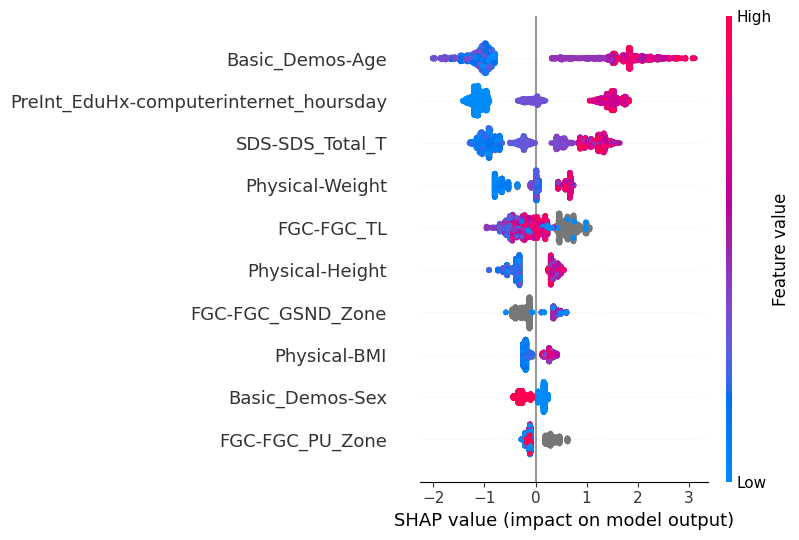

In [163]:
# this code might not be right
# double check what's going on with the dimensions of the shap output
from catboost import Pool
import shap
shap_values = model.get_feature_importance(
    Pool(X,y), #, cat_features=cat_features # include if you have any categorical features
    type='ShapValues') # shape is (obsevations, targets + 1, features + 1) last target is expected value and last feature is constant
print(shap_values.shape)

# Extract expected value and separate SHAP values
expected_values = shap_values[:, -1, :]  # Expected values for each target
shap_values = shap_values[:, :-1, :]     # Remove the expected value column

# Select target index
target_idx = TARGET_COLS.index("PCIAT-PCIAT_Total")
shap_values_target = shap_values[:, target_idx, :]

# Plot SHAP summary
shap.summary_plot(shap_values_target[:,:-1], X, max_display=10) # have to remove intercept

# Optional: Plot force plot for the first instance
# instance_idx = 0
# shap.force_plot(
#     expected_values[target_idx], 
#     shap_values_target[instance_idx, :-1], 
#     X.to_pandas().iloc[instance_idx, :-1]
# )


Text(0.5, 1.0, 'Feature Importance')

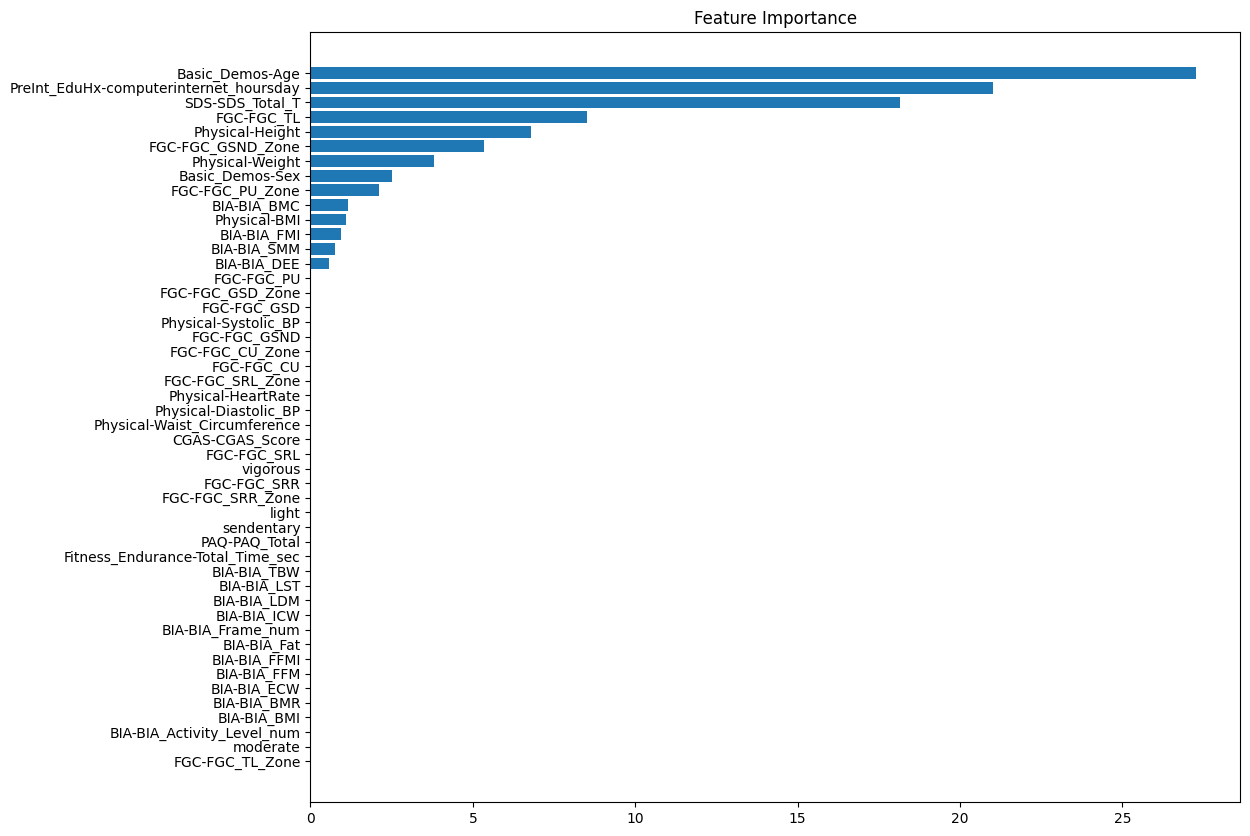

In [164]:
# feature importance based on whole training dataset
feature_importance = model.get_feature_importance()
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title("Feature Importance")

In [167]:
# predict based on model fit on whole dataset
y_test_pred = model.predict(X_test)
y_test_pred_total = y_test_pred[:, TARGET_COLS.index("PCIAT-PCIAT_Total")]
y_test_pred_total = (y_test_pred_total - y_test_pred_total.min()) / (y_test_pred_total.max() - y_test_pred_total.min()) * (4 - 1)
y_test_pred_rounded = np.digitize(y_test_pred_total, optimizer.thresholds)
print(y_test_pred_rounded)

# Create a DataFrame for submission
submission_df = pd.DataFrame({
    "id": test_data_cleaned["id"],  # Assuming your test set has an "ID" column
    "sii": y_test_pred_rounded
})

# Export to CSV
submission_df.to_csv("submission.csv", index=False)

print("Submission file created successfully!")
display(submission_df)

[0 0 1 0 2 2 1 1 3 2 1 1 2 1 2 1 0 0 1 1]
Submission file created successfully!


,id,sii
0,00008ff9,0
1,000fd460,0
2,00105258,1
3,00115b9f,0
4,0016bb22,2
5,001f3379,2
6,0038ba98,1
7,0068a485,1
8,0069fbed,3
9,0083e397,2


In [166]:
# Testing average predictions instead of full model predictions
# Predict on test set
# y_test_pred = np.zeros((X_test.shape[0], len(TARGET_COLS)))

# for model in models:
#     y_test_pred += model.predict(X_test)

# # Average the predictions from all models
# y_test_pred /= len(models)

# # Round predictions using the optimized thresholds
# y_test_pred_total = y_test_pred[:, TARGET_COLS.index("PCIAT-PCIAT_Total")]
# y_test_pred_rounded = optimizer.predict(y_test_pred_total)

# # Create a DataFrame for submission
# submission_df = pd.DataFrame({
#     "id": test["id"],  # Assuming your test set has an "ID" column
#     "sii": y_test_pred_rounded
# })

# # Export to CSV
# submission_df.to_csv("submission.csv")

# print("Submission file created successfully!")
# display(submission_df)